In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
if 'google.colab' in sys.modules:
  if not os.path.isdir('/content/drive/'):
    from google.colab import drive
    drive.mount('/content/drive/')

  %cd /content/drive/MyDrive/engg680_course_project/

In [ ]:
import pickle

import torch
import torch.nn as nn
from torch.nn import functional as F

from input import Input_Data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data = Input_Data()
data.load_data("./models/station_features_v2.csv")
data.init_split()

In [4]:
from gpt import PM25TransformerModel, batch_size, block_size, stations_in_batch, target_size

torch.no_grad()
transformer_model = PM25TransformerModel(data)
transformer_model.load_state_dict(torch.load("./models/five_years.model", weights_only=True))
transformer_model.to(device)
transformer_model.eval()

with open("./models/transformer_losses.loss", "rb") as fp:
    transformer_losses = pickle.load(fp)

print("Done")

Done


In [6]:
from linear import LinearModel, batch_size, block_size

torch.no_grad()
linear_model = LinearModel(data)
linear_model.load_state_dict(torch.load("./models/five_years_linear.model", weights_only=True))
linear_model.to(device)
linear_model.eval()

with open("./models/linear_losses.loss", "rb") as fp:
    linear_losses = pickle.load(fp)

print("Done")

Done


In [143]:
def test_error(model):
    torch.manual_seed(1337)
    iter = 500

    mse_losses = torch.zeros(iter)
    r2_losses = torch.zeros(iter)

    for k in range(iter):
        batch = data.get_batch('test', batch_size, block_size, target_size, device)
        logits, mse_loss, r2 = model(batch)
        mse_losses[k] = mse_loss.item()
        r2_losses[k] = r2

    print(f"MSE: {mse_losses.mean()}")
    print(f"r2: {r2_losses.mean()}")

print("Transformer model")
test_error(transformer_model)
print("Linear Model")
test_error(linear_model)

Transformer model
MSE: 2.4570435925852507e-05
r2: -0.4210587441921234
Linear Model
MSE: 3.324101385260292e-07
r2: 0.9605646729469299


In [150]:
from sklearn.metrics import r2_score

def gen_24(model):
    torch.manual_seed(1337)
    iter = 500
    hours = 24

    mse_losses = torch.zeros(iter)
    r2_losses = torch.zeros(iter)

    for k in range(iter):
        batch = data.get_batch_target('test', batch_size, block_size, hours, device)
        gen = model.generate(batch, hours)

        targets, _ = torch.split(batch[1], 1, dim=-1)
        targets = targets.view(batch_size, hours)
        mse_loss = model.mse_loss(model.normalize(gen), model.normalize(targets))
        mse_losses[k] = mse_loss.item()
        r2_losses[k] = r2_score(targets.detach().cpu().numpy().flatten(), gen.detach().cpu().numpy().flatten())

    print(f"MSE: {mse_losses.mean()}")
    print(f"r2: {r2_losses.mean()}")

print("Transformer model")
gen_24(transformer_model)
print("Linear Model")
gen_24(linear_model)

Transformer model
MSE: 2.572421908553224e-05
r2: -0.39508315920829773
Linear Model
MSE: 6.177249451866373e-05
r2: -6.84506893157959


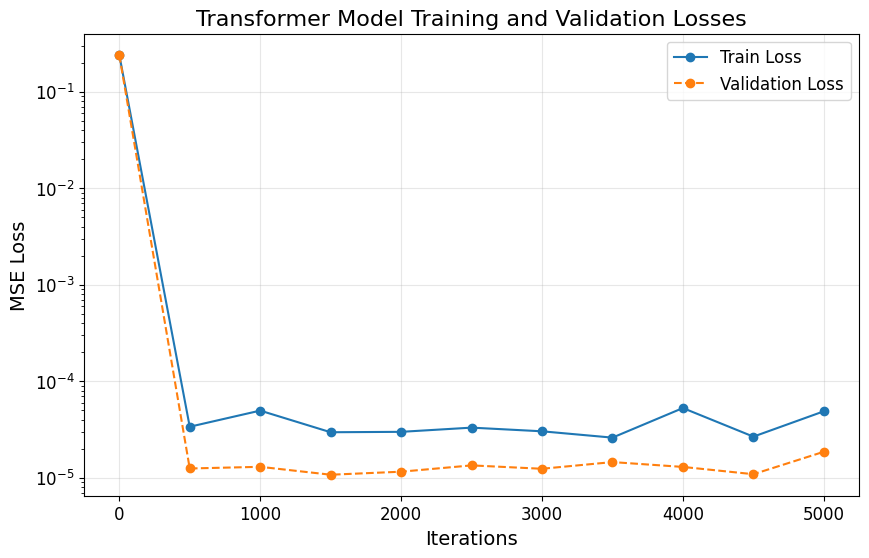

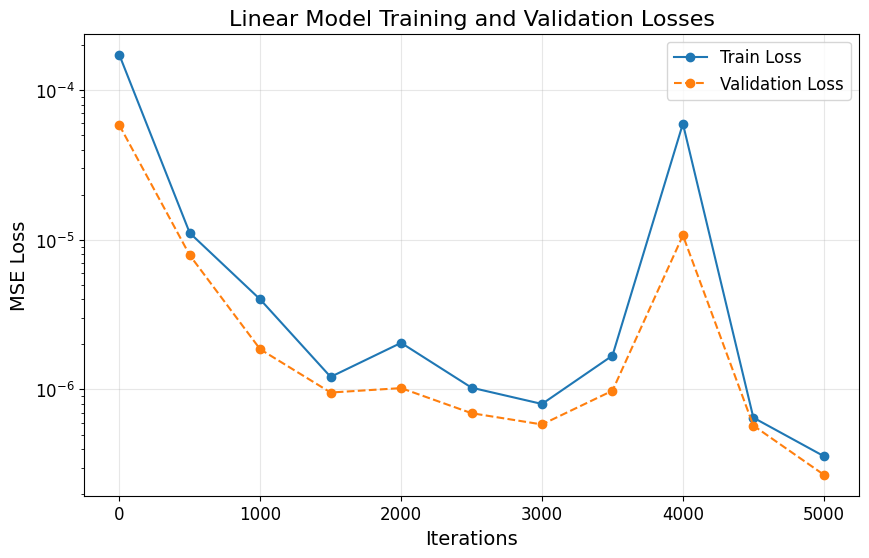

In [7]:
import matplotlib.pyplot as plt

def train_val_loss_graph(losses, name):
    # Example loss lists (replace these with your actual data)
    # Assuming each entry corresponds to the loss value at 500 iterations
    train_losses = [item['train'][0].item() for item in losses]
    val_losses = [item['val'][0].item() for item in losses]

    # Define the iteration checkpoints
    iterations = [500 * (i) for i in range(len(losses))]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, train_losses, label='Train Loss', marker='o', linestyle='-')
    plt.plot(iterations, val_losses, label='Validation Loss', marker='o', linestyle='--')

    plt.yscale('log')

    # Formatting
    plt.title(name, fontsize=16)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('MSE Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show plot
    plt.show()

train_val_loss_graph(transformer_losses, 'Transformer Model Training and Validation Losses')
train_val_loss_graph(linear_losses, 'Linear Model Training and Validation Losses')